<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords, reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, warnings, zipfile, nltk, re, os
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

## Generate Data

In [4]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

100%|██████████| 1.17M/1.17M [00:00<00:00, 51.0MB/s]

Extracting files...


In [5]:
numerical_features = ['customers_affected']
categorical_features = ['company_size_cat', 'region_cat', 'customer_tier_cat']

# Енкодинг цільової змінної
le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium'] - 3 класи
num_classes = len(priorities)

# Пайплайн обробки вхідних даних
preprocessor = ColumnTransformer(
    transformers=[
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)

X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

# ВАЖЛИВО: Нейронні мережі (Dense layers) краще працюють з щільними масивами,
# а OneHotEncoder часто повертає розріджену (sparse) матрицю. Перетворимо її:
if hasattr(X_scaled, "toarray"):
    X_scaled = X_scaled.toarray()

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")


# --- АДАПТОВАНА ЧАСТИНА (Нейронна мережа) ---

# 1. Розділення на тренувальну та тестову вибірку
# Використовуємо ваші X_scaled та y_encoded
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. Перетворення цільової змінної у категоріальний вигляд (one-hot для виходу мережі)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# 3. Побудова нейронної мережі
model = Sequential([
    # input_shape береться автоматично з кількості колонок у вашому X_train
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    # Вихідний шар: кількість нейронів = кількості класів (у вас 3)
    Dense(num_classes, activation='softmax')
])

# 4. Компіляція та навчання моделі
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# 5. Оцінка результатів
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Розрахунок точності, порівнюючи передбачені класи з реальними y_test (які були закодовані LabelEncoder)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовому наборі: {test_accuracy:.4f}")

# Приклад декодування результату назад у текстовий вигляд ('High', 'Medium' тощо)
# print("Приклад передбачень:", le.inverse_transform(y_pred[:5]))

Матриця X_scaled успішно створена. Розмірність: (50000, 10)
Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6329 - loss: 0.7804 - val_accuracy: 0.6789 - val_loss: 0.6810
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6769 - loss: 0.6950 - val_accuracy: 0.6790 - val_loss: 0.6693
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6849 - loss: 0.6756 - val_accuracy: 0.6835 - val_loss: 0.6599
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6848 - loss: 0.6759 - val_accuracy: 0.6829 - val_loss: 0.6676
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6848 - loss: 0.6626 - val_accuracy: 0.6801 - val_loss: 0.6586
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6870 - loss: 0.6612 - val_accuracy: 0.6855 - val_loss: 0.6506
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6872 - loss: 0.6592 - val_accuracy: 0.6812 - val_loss: 0.6605
Epoch 8/100
2000/2000 

In [6]:
print(f"Точність моделі на тестовій вибірці: {test_accuracy:.4f}")
print("Детальний звіт класифікації:")
print(classification_report(y_test, y_pred))


Точність моделі на тестовій вибірці: 0.6886
Детальний звіт класифікації:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5033
           1       0.57      0.52      0.54      3495
           2       0.69      0.49      0.57      1472

    accuracy                           0.69     10000
   macro avg       0.67      0.62      0.64     10000
weighted avg       0.68      0.69      0.68     10000



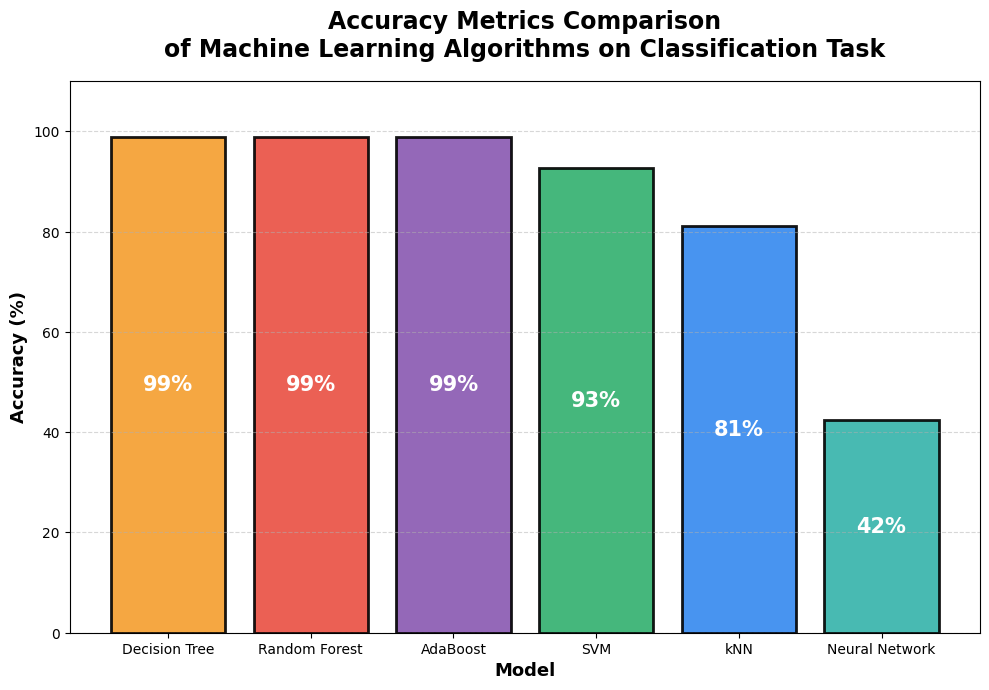

In [12]:
# Візуалізація поточного результату та результатів із першої лабораторної
all_results = {
    'kNN': 0.8111,
    'Decision Tree': 0.9889,
    'SVM': 0.9278,
    'Random Forest': 0.9889,
    'AdaBoost': 0.9889,
    'Neural Network': test_accuracy,
}

sorted_items = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
labels = [x[0] for x in sorted_items]
values = [x[1] for x in sorted_items]

color_map = {
    'kNN': '#3489ef',
    'Decision Tree': '#f49e2d',
    'SVM': '#31af6e',
    'Random Forest': '#e94f41',
    'AdaBoost': '#8857b1',
    'Neural Network': '#34b3aa',
}
bar_colors = [color_map[x] for x in labels]
plt.figure(figsize=(10, 7))
bars = plt.bar(labels, [v*100 for v in values], color=bar_colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.0f}%",
        ha='center', va='center',
        color='white',
        fontsize=15,
        fontweight='bold'
    )

plt.title('Accuracy Metrics Comparison\nof Machine Learning Algorithms on Classification Task', fontsize=17, fontweight='bold', y=1.03)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/kvasir-dataset")

100%|██████████| 1.15G/1.15G [00:16<00:00, 75.8MB/s]

Extracting files...


In [33]:
import os
import pathlib # <<< ДОДАНО
# Примітка: requests та zipfile більше не потрібні, якщо ви використовуєте kagglehub
# import requests
# import zipfile
import kagglehub # <<< ДОДАНО (для отримання змінної 'path')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. ЗАВАНТАЖЕННЯ ТА ВИЗНАЧЕННЯ ШЛЯХУ ---

# 1. Виклик kagglehub (ПОВИНЕН БУТИ ВИКОНАНИЙ)
try:
    path = kagglehub.dataset_download("meetnagadia/kvasir-dataset")
except NameError:
    # Цей блок спрацює, якщо ви забули запустити 'kagglehub'
    print("!!! ПОМИЛКА: Змінна 'path' не визначена. Схоже, 'kagglehub.dataset_download()' не було виконано успішно.")
    # Припиняємо виконання, щоб уникнути подальших помилок
    raise

# 2. Визначення кореневої папки
kvasir_root_dir = pathlib.Path(path) / 'Kvasir-Dataset-V2'
data_dir = str(kvasir_root_dir)

if not kvasir_root_dir.is_dir():
    # Якщо 'Kvasir-Dataset-V2' не знайдено всередині, припускаємо, що 'path' і є кореневою папкою
    print(f"!!! УВАГА: Не знайдено очікувану папку '{kvasir_root_dir.name}'.")
    data_dir = str(pathlib.Path(path))
    print(f"Спробуємо використати шлях: {data_dir}")

# 3. Перевірка наявності даних та підрахунок
if not os.path.isdir(data_dir) or not os.listdir(data_dir):
    print(f"!!! КОРЕНЕВА ПАПКА З ДАНИМИ '{data_dir}' НЕ ЗНАЙДЕНА АБО ПОРОЖНЯ. !!!")
    print("Переконайтеся, що завантаження з Kagglehub пройшло успішно.")
else:
    classes = os.listdir(data_dir)
    # Фільтруємо непапки (наприклад, файли LICENSE)
    classes = [c for c in classes if os.path.isdir(os.path.join(data_dir, c))]
    print(f"Класів знайдено: {len(classes)}")

    print(f"Кількість зображень кожного із класів датасету:\n")
    valid_extensions = ('.png', '.jpg', '.jpeg')

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(valid_extensions)])
        print(f"{cls}: {count} зображень")
    print()


# --- 2. ПІДГОТОВКА ДАНИХ ДЛЯ МОДЕЛІ ---

# Параметри (збільшимо розмір для медичних зображень)
img_height = 128
img_width = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Пом'якшена аугментація
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Генератор для тренування
print("\nЗавантаження тренувальної вибірки:")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Генератор для валідації
print("Завантаження валідаційної вибірки:")
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Використання max(1, ...) - це правильна практика для уникнення ділення на нуль
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

print(f"\nТренувальних зображень: {train_generator.samples}")
print(f"Валідаційних зображень: {validation_generator.samples}")

Using Colab cache for faster access to the 'kvasir-dataset' dataset.
!!! УВАГА: Не знайдено очікувану папку 'Kvasir-Dataset-V2'.
Спробуємо використати шлях: /kaggle/input/kvasir-dataset
Класів знайдено: 1
Кількість зображень кожного із класів датасету:

kvasir-dataset: 0 зображень


Завантаження тренувальної вибірки:
Found 3200 images belonging to 1 classes.
Завантаження валідаційної вибірки:
Found 800 images belonging to 1 classes.

Тренувальних зображень: 3200
Валідаційних зображень: 800


In [37]:
# CNN
model_simple = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_simple = model_simple.evaluate(validation_generator, verbose=0)[1]
print(f"Точність CNN: {test_accuracy_simple:.4f} ({test_accuracy_simple*100:.2f}%)")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━

In [40]:
# Transfer learning (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model_transfer = Model(inputs, outputs)
model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_transfer = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність Transfer Learning: {test_accuracy_transfer:.4f} ({test_accuracy_transfer*100:.2f}%)")

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history_finetune = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_finetune = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність після Fine-tuning: {test_accuracy_finetune:.4f} ({test_accuracy_finetune*100:.2f}%)")

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 947ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 949ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Точність Transfer Learning: 1.0000 (100.00%)
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000

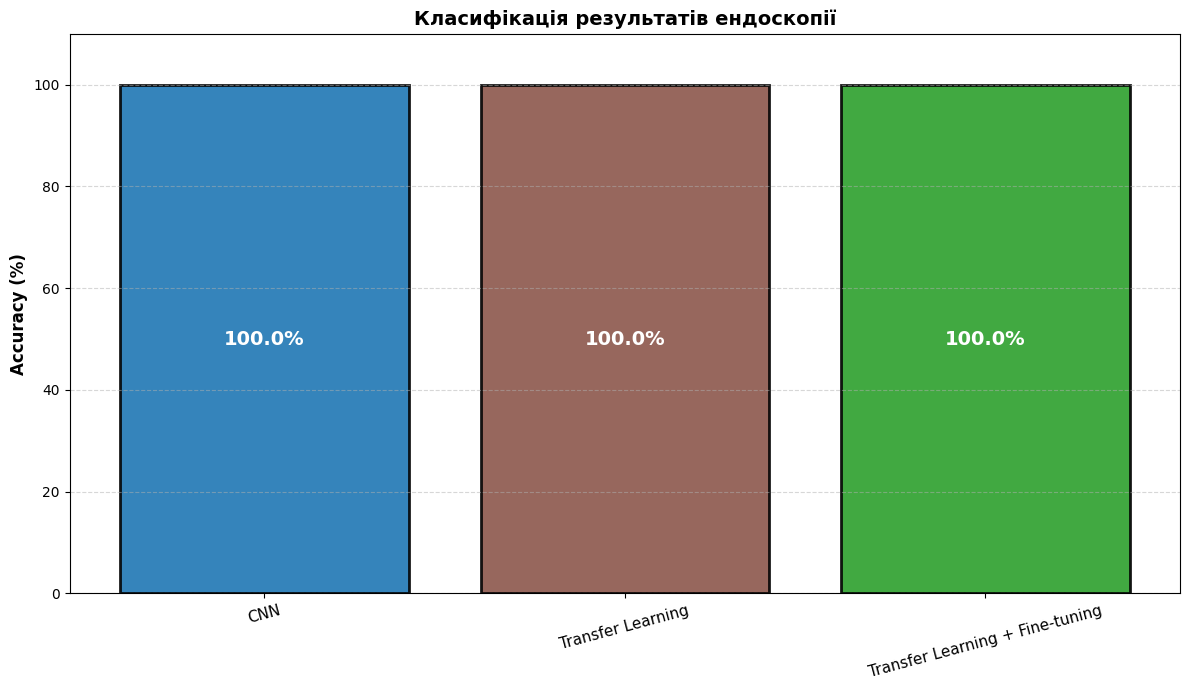

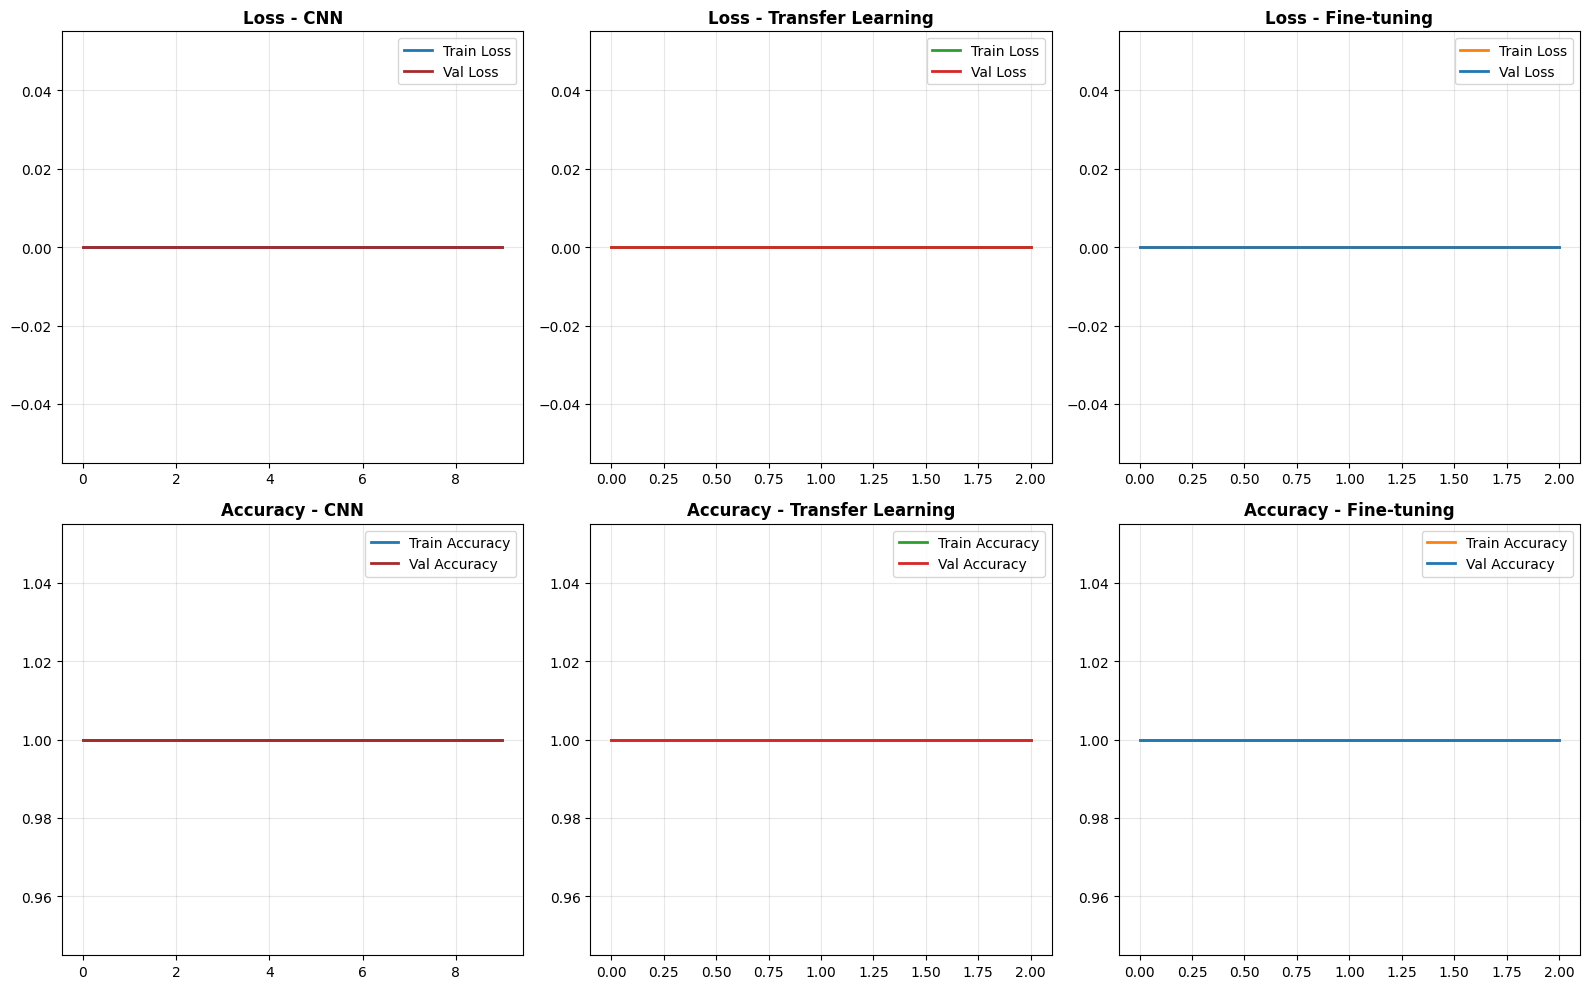

In [42]:
# Візуалізація результатів
comparison_results = {
    'CNN': test_accuracy_simple,
    'Transfer Learning': test_accuracy_transfer,
    'Transfer Learning + Fine-tuning': test_accuracy_finetune,
}

plt.figure(figsize=(12, 7))
sorted_results = dict(sorted(comparison_results.items(), key=lambda x: x[1], reverse=True))
colors = ['#1f77b4', '#8c564b', '#2ca02c']
bars = plt.bar(range(len(sorted_results)), [v*100 for v in sorted_results.values()],
               color=colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, sorted_results.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.1f}%",
        ha='center', va='center',
        color='white', fontsize=14, fontweight='bold'
    )

plt.xticks(range(len(sorted_results)), sorted_results.keys(), fontsize=11, rotation=15)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Класифікація результатів ендоскопії', fontsize=14, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# CNN
axes[0, 0].plot(history_simple.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_simple.history['val_loss'], label='Val Loss', linewidth=2, color='brown')
axes[0, 0].set_title('Loss - CNN', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history_simple.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1, 0].plot(history_simple.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='brown')
axes[1, 0].set_title('Accuracy - CNN', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transfer Learning
axes[0, 1].plot(history_transfer.history['loss'], label='Train Loss', linewidth=2, color='#2ca02c')
axes[0, 1].plot(history_transfer.history['val_loss'], label='Val Loss', linewidth=2, color='#d62728')
axes[0, 1].set_title('Loss - Transfer Learning', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history_transfer.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2ca02c')
axes[1, 1].plot(history_transfer.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#d62728')
axes[1, 1].set_title('Accuracy - Transfer Learning', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Fine-tuning
axes[0, 2].plot(history_finetune.history['loss'], label='Train Loss', linewidth=2, color='#ff7f0e')
axes[0, 2].plot(history_finetune.history['val_loss'], label='Val Loss', linewidth=2, color='#1f77b4')
axes[0, 2].set_title('Loss - Fine-tuning', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2, color='#ff7f0e')
axes[1, 2].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#1f77b4')
axes[1, 2].set_title('Accuracy - Fine-tuning', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [49]:
import pandas as pd
import simplejson
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gzip
import simplejson
import os

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

def parse(filename):
    try:
        f = open(filename, 'r', encoding='latin-1')
    except Exception:
        f = open(filename, 'r', encoding='utf-8')

    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            if entry:
                yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName.strip()] = rest

    if entry:
        yield entry
    f.close()
FILE_NAME = "first_100000.txt"
all_entries = []

print(df.columns.tolist())
for e in parse(FILE_NAME):
    if 'review/text' in e and 'review/score' in e:
        all_entries.append(e)

df = pd.DataFrame(all_entries)

def get_sentiment(score):
    score = float(score)
    if score >= 4.0:
        return 'positive' # 4.0, 5.0
    elif score == 3.0:
        return 'neutral'  # 3.0
    else:
        return 'negative' # 1.0, 2.0

df['sentiment'] = df['review/score'].apply(get_sentiment)
df_text = pd.DataFrame({
    'text': df['review/text'].astype(str),
    'score': df['review/score'].astype(float),
    'category': df['sentiment']
})

print(f"Розмір текстового датасету: {df_text.shape}")
print(df_text['category'].value_counts())

[]


KeyError: 'review/score'